# BoottleNeck Análisis V.6

Después de haber entregado el análisis preliminar al cliente, en donde encontramos los valores del __flujo promedio limpio__ (en camiones por hora) para cada zona operacional, es momento de dar un vuelco y comenzar a procesar los datos conforme a encontrar patrones o indicadores de cuellos de botella dentro de CS. Para ello tomaremos la siguiente estructura.

1. Estructuración de los datos.
2. Calculo de estadísticos
3. Representación de estos. 

---

Para entender mejor la estructuración de los datos es necesario comprender ciertos objetivos y conceptos.

__Objetivo Principal__: Comprender el funcionamiento de la faena CS a través del análisis de los tiempos de espera y atención para cada Zona Operacional (ZO)

__Estrategia__: Buscar información en bloques de 30 minutos.

Tendremos 3 tipos de estatus:
1. Atención: cuando un camión se encuentra dentro de una ZO
2. Espera: cuando un camión está en espera o tránsito a una ZO
3. Out: Cuando el camión se encuentra fuera de la faena CS

Qué pretendemos encontrar en cada bloque establecido, para Atención y Espera?
1. N° de camiones que ingresaron y salieron de una ZO
2. N° de camiones que estaban en una ZO al inicio del bloque.
3. Tiempo acumulado de atención (SUM_i (t_i) = Tiempo acumulado).
4. Promedio, moda, media, max, min de tiempos de atención
5. Promedio, moda, media, max, min en el conteo de vehículos en Espera y Atención.

__Conceptos importantes__

1. __Tiempos de IDLE__: cuando tenemos una ZO inactiva y sin camiones en espera
2. __Tiempos de inactividad__: cuando tenemos una ZO inactiva y con camiones en espera
3. __Tiempos de Transición__: corresponden a los tiempos de salida y llegada de camiones (se estima que el máximo debe ser 5 min).


---

# 1. Estructuración de los datos 

Tomaremos en consideración los filtros aplicados en la sección de preprocesado, dejando como consideración las fechas, destino, origen, producto y tipo de acción,es decir descarga o carga.

Además, __eliminamos los viajes que van desde CS a CS__, ya que poseen una trato especial dentro de la Faena, segun lo conversado con Pedro, es decir estos tienen preferecias y no ocupan lugar dentro de las canchas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns

In [2]:
df = pd.read_csv("BoottleNeck_filtered_v3.csv", engine='python')

cols = ['Year [Out]','Month [In]','Month [Out]','Day [In]','Day [Out]','Hour [In]','Hour [Out]']

#Convertimos Zone start y end en .time (hh:mm:ss)
for i in range(1,99):
    zone_1 = "Zone Start (%s)"%i
    zone_2 = "Zone End (%s)"%i
    df[zone_1] = pd.to_datetime(df[zone_1], utc = True).dt.tz_convert('Chile/Continental').dt.time
    df[zone_2] = pd.to_datetime(df[zone_2], utc = True).dt.tz_convert('Chile/Continental').dt.time
df["Date [In]"] = df['Year [In]'].astype(str) + "-" + df["Month [In]"].astype(str) + "-" + df["Day [In]"].astype(str)+" "+df['Hour [In]'].astype(str)+":00:00"
df["Date [In]"] = pd.to_datetime(df["Date [In]"],utc = True)
df["Date [Out]"] = df['Year [Out]'].astype(str) + "-" + df["Month [Out]"].astype(str) + "-" + df["Day [Out]"].astype(str)+" "+df['Hour [Out]'].astype(str)+":00:00"
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"],utc = True)
#convertimos utc a Chile/Continental
df['Date [In]']=pd.to_datetime(df['Date [In]'], utc = True).dt.tz_convert('Chile/Continental')
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"],utc = True).dt.tz_convert('Chile/Continental')

df['Day of year [In]']=pd.to_datetime(df['Date [In]']).dt.dayofyear
df['Day of year [Out]']=pd.to_datetime(df['Date [Out]']).dt.dayofyear

#Dejamos Date [In] como estaba
df["Date [In]"] = pd.to_datetime(df["Date [In]"]).dt.date
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"]).dt.date
df=df.drop(cols,axis=1)
df

Cycle Id  Year [In]      Type      Product            Origin  \
0      10242520       2019     Carga  NPC-TA 50 F          Coya Sur   
1      10242540       2019  Descarga          NaN         Tocopilla   
2       9250786       2019     Carga          NaN          Coya Sur   
3       8143041       2019     Carga          NaN          Coya Sur   
4       8903979       2019     Carga          NaN          Coya Sur   
...         ...        ...       ...          ...               ...   
93195  18633231       2020  Descarga         SNIT    Nueva Victoria   
93196  18633167       2020     Carga          NaN          Coya Sur   
93197  18633133       2020  Descarga         SNIT    Nueva Victoria   
93198  18633510       2020  Descarga     MOP-H-BL  Salar de Atacama   
93199  18633550       2020  Descarga     MOP-H-BL  Salar de Atacama   

          Destination   Zone Name (1)  Zone Pre Time (1) Zone Start (1)  \
0           Tocopilla  Romana Salitre              249.0       11:30:58   
1            Coya Sur    C Secado L-4             5664.0       17:28:39   
2      Nueva Victoria           C PTS                0.0       20:00:09   
3      Nueva Victoria          C NPT3              601.0       20:41:50   
4      Nueva Victoria          C NPT3              685.0       21:10:25   
...               ...             ...                ...            ...   
93195        Coya Sur             NaN                NaN            NaT   
93196   Virtual_Place          C NPT3              760.0       01:45:18   
93197        Coya Sur             NaN                NaN            NaT   
93198        Coya Sur          C NPT3              715.0       01:46:43   
93199        Coya Sur          C NPT3             1175.0       01:55:39   

      Zone End (1)  ...  Zone Time (97) Zone Name (98)  Zone Pre Time (98)  \
0         11:35:06  ...             NaN            NaN                 NaN   
1         17:35:53  ...             NaN            NaN                 NaN   
2         20:05:52  ...             NaN            NaN                 NaN   
3         20:46:50  ...             NaN            NaN                 NaN   
4         21:15:25  ...             NaN            NaN                 NaN   
...            ...  ...             ...            ...                 ...   
93195          NaT  ...             NaN            NaN                 NaN   
93196     01:54:19  ...             NaN            NaN                 NaN   
93197          NaT  ...             NaN            NaN                 NaN   
93198     01:53:46  ...             NaN            NaN                 NaN   
93199     02:01:05  ...             NaN            NaN                 NaN   

      Zone Start (98) Zone End (98)  Zone Time (98)   Date [In]  Date [Out]  \
0                 NaT           NaT             NaN  2019-06-30  2019-06-30   
1                 NaT           NaT             NaN  2019-06-30  2019-06-30   
2                 NaT           NaT             NaN  2019-06-30  2019-06-30   
3                 NaT           NaT             NaN  2019-06-30  2019-06-30   
4                 NaT           NaT             NaN  2019-06-30  2019-06-30   
...               ...           ...             ...         ...         ...   
93195             NaT           NaT             NaN  2020-06-08  2020-06-08   
93196             NaT           NaT             NaN  2020-06-08  2020-06-08   
93197             NaT           NaT             NaN  2020-06-08  2020-06-08   
93198             NaT           NaT             NaN  2020-06-08  2020-06-08   
93199             NaT           NaT             NaN  2020-06-08  2020-06-08   

      Day of year [In] Day of year [Out]  
0                  181               181  
1                  181               181  
2                  181               181  
3                  181               181  
4                  181               181  
...                ...               ...  
93195              160               160  
93196              160 

# Tenemos Varias Tareas para esta oportunidad.

* Obtener peaks de cargas y descargas, para CS-NV o viceversa, de forma de contrastar los camiones que llegan de CS-NV de los que vienen de Salar.
* Obtener tiempos de espera, para complementar con información de la semana anterior
* Diferencia entre Salar y NV en las canchas mostradas la vez pasada, NPT3, NPT4, CS-4
* Gráfico de solo SNIT y Silvinita-MOP H para la NPT3, HACER UN FACING DE LLEGADA.

## Encontraremos los Peaks y diferenciaremos por producto

Realizaremos el análisis solamente para el mes de enero en particular.

In [67]:
zonas = ['Romana Salitre', 'C Secado L-4', 'C PTS', 'C NPT3', 'Romana Mto', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
 'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'Romana 3', 'C CS-11']

def block_generator(df,dia_inicio,dia_fin,inicio,fin,condition='in'):
    """Entregamos un Año, mes, día  y el rango de horas entre las cuales se quiere tener el bloque, 
       hr:min:seg > block >hr_:min_:seg_ """
    cont = 0
    for i in range(1,99):
        zone_1 = "Zone Name (%s)"%i
        zone_2 = "Zone Pre Time (%s)"%i
        zone_3 = "Zone Start (%s)"%i
        zone_4 = "Zone End (%s)"%i
        zone_5 = "Zone Time (%s)"%i

        cols=['Cycle Id', 'Origin', 'Destination','Type','Product','Date [In]','Date [Out]','Day of year [In]','Day of year [Out]',
              zone_1, zone_2, zone_3, zone_4, zone_5]

        date_lower = datetime.time(inicio[0], inicio[1], inicio[2])
        date_upper = datetime.time(fin[0], fin[1], fin[2])
        
        if (condition == 'in'):
            a = df[(df[zone_3] < date_upper) & (df[zone_3] >= date_lower) & (df['Day of year [In]'] >= dia_inicio) & (df['Day of year [In]'] <= dia_fin)]
        elif (condition == 'out'):
            a = df[(df[zone_4] < date_upper) & (df[zone_4] >= date_lower) & (df['Day of year [Out]'] >= dia_inicio) & (df['Day of year [Out]'] <= dia_fin)]
        else:
            break
        b = a.loc[:,cols]
        b = b.rename(columns={zone_1:"Name ZO",
                          zone_2:"Pre Time",
                          zone_3:"Start",
                          zone_4:"End",
                          zone_5:"Time"})    
        if cont == 0:
            block = b
            cont += 1
            continue
        else:
            block = pd.concat([block, b], axis=0, sort=False) 
    block = block.sort_values(['Cycle Id', 'Name ZO',"Date [In]"], ascending=[True,True,True])
    return block

#Vehiculos ingresados
def vehiculos(df,dia_inicio,dia_fin,inicio=1,fin=25,condition='in'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos ingresados} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        if (condition == 'out'):
            df_ = block_generator(df,dia_inicio,dia_fin,start,end,condition=condition)
            date_lower = datetime.time(start[0], start[1], start[2])
            date_upper = datetime.time(end[0], end[1], end[2])
        elif (condition == 'in'):
            df_ = block_generator(df,dia_inicio,dia_fin,start,end,condition=condition)
        else:
            break
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            if (condition == 'out'):
                block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            vehiculos_in = block_filtered.shape[0]
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    diccionario[zo].update({i:vehiculos_in})
                else:
                    diccionario.update({zo:{i:vehiculos_in}})
    return diccionario

def vehiculos_time(df,dia_inicio,dia_fin,inicio=1,fin=25,condition='in',cond='time'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos salieron} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(df,dia_inicio,dia_fin,start,end,condition=condition)
        date_lower = datetime.time(start[0], start[1], start[2])
        date_upper = datetime.time(end[0], end[1], end[2])
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            if(cond=='Pre Time'):
                cumulative_time = block_filtered['Pre Time'].shape[0]
            else:
                cumulative_time = block_filtered.Time.sum()
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    if(cond == 'Pre Time' ):
                        diccionario[zo].update({i:(cumulative_time)})
                    else:
                        diccionario[zo].update({i:(cumulative_time/60)})
                else:
                    if(cond == 'Pre Time' ):
                        diccionario.update({zo:{i:(cumulative_time)}})
                    else:
                        diccionario.update({zo:{i:(cumulative_time/60)}})
    return diccionario

def dict_to_df(dictionary):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    count=0
    for k, v in dictionary.items():
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        if (count == 0):
            b = a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0)
    cols_b = b.keys().tolist()
    diff = list(set(zonas) - set(cols_b))
    if (len(diff) > 0):
        for i in diff:
            b[i] = 0
    b = b.reindex(sorted(b.columns), axis=1)
    return b

def convert_df_dt(df):
    for i in range(1,99):
        zone_1 = "Zone Start (%s)"%i
        zone_2 = "Zone End (%s)"%i
        df[zone_1] = pd.to_datetime(df[zone_1]).dt.time
        df[zone_2] = pd.to_datetime(df[zone_2]).dt.time
    df["Date [In]"] = pd.to_datetime(df["Date [In]"]).dt.date
    df["Date [Out]"] = pd.to_datetime(df["Date [Out]"]).dt.date
    return df

Reordenamos el Dataset para luego hacer el análisis por mes. Crearemos Nuevos Dataset por Tramos esta vez, es decir por viajes.

In [4]:
def df_origin_destination(df, zona_1 , zona_2 ,name = None):    
    aux = df[((df['Origin'] == zona_1) | (df['Origin'] == zona_2)) & ((df['Destination'] == zona_1) | (df['Destination'] == zona_2)) ]
    if name != None:
        aux.to_csv(name,index=False)
    return aux

zona_1 = 'Coya Sur'
zona_2 = 'Nueva Victoria'
data = df
data = df_origin_destination(data,zona_1,zona_2,"cs-nv.csv")

In [5]:
#Cargamos el nuevo DS
#data = pd.read_csv('cs-nv.csv')
carga = data[data['Type'] == 'Carga']
descarga = data[data['Type'] == 'Descarga']

Podemos notar que los viajes que van desde CS a NV no poseen etiqueta de producto, más bien son NaN, esto se debe a que efectivamente no llevan productos, solamente van a NV a cargar, son camiones sin carga.
Por otro lado los que vienen de NV a CS traen la carga de SNIT, esos vienen etiquetados, a pesar de que hay 243 elementos que presentan NaN en sus etiquetas

In [6]:
carga.iloc[:,:20]

Cycle Id  Year [In]   Type Product    Origin     Destination  \
2       9250786       2019  Carga     NaN  Coya Sur  Nueva Victoria   
3       8143041       2019  Carga     NaN  Coya Sur  Nueva Victoria   
4       8903979       2019  Carga     NaN  Coya Sur  Nueva Victoria   
5       8343219       2019  Carga     NaN  Coya Sur  Nueva Victoria   
8      10586568       2019  Carga     NaN  Coya Sur  Nueva Victoria   
...         ...        ...    ...     ...       ...             ...   
93093  18620623       2020  Carga     NaN  Coya Sur  Nueva Victoria   
93116  18623746       2020  Carga     NaN  Coya Sur  Nueva Victoria   
93132  18626073       2020  Carga     NaN  Coya Sur  Nueva Victoria   
93143  18628463       2020  Carga     NaN  Coya Sur  Nueva Victoria   
93153  18629557       2020  Carga     NaN  Coya Sur  Nueva Victoria   

        Zone Name (1)  Zone Pre Time (1) Zone Start (1) Zone End (1)  \
2               C PTS                0.0       20:00:09     20:05:52   
3              C NPT3              601.0       20:41:50     20:46:50   
4              C NPT3              685.0       21:10:25     21:15:25   
5              C NPT3             1687.0       21:42:00     21:50:41   
8               C PTS             2281.0       22:06:38     22:11:20   
...               ...                ...            ...          ...   
93093          C NPT3             2465.0       16:57:09     17:10:33   
93116  Romana Salitre             1175.0       17:51:57     17:56:57   
93132  Romana Salitre             3023.0       19:24:38     19:39:54   
93143          C NPT3              713.0       20:21:42     20:26:20   
93153          C CS-4             1150.0       21:18:12     21:27:13   

       Zone Time (1) Zone Name (2)  Zone Pre Time (2) Zone Start (2)  \
2              343.0        Salida                0.0       20:05:52   
3              300.0        Salida                0.0       20:46:50   
4              300.0        Salida                0.0       21:15:25   
5              521.0        Salida                0.0       21:50:41   
8              282.0        Salida                0.0       22:11:20   
...              ...           ...                ...            ...   
93093          804.0        Salida                0.0       17:10:33   
93116          300.0        C NPT4              622.0       18:07:19   
93132          916.0        C NPT4                0.0       19:39:54   
93143          278.0        Salida                0.0       20:26:20   
93153          541.0        Salida                0.0       21:27:13   

      Zone End (2)  Zone Time (2) Zone Name (3)  Zone Pre Time (3)  \
2         20:10:10          258.0           NaN                NaN   
3         20:51:50          300.0           NaN                NaN   
4         21:22:25          420.0           NaN                NaN   
5         21:56:02          321.0           NaN                NaN   
8         22:20:39          559.0           NaN                NaN   
...            ...            ...           ...                ...   
93093     17:19:33          540.0           NaN                NaN   
93116     18:17:28          609.0        C NPT4              180.0   
93132     19:45:33          339.0        Salida                0.0   
93143     20:32:48          388.0           NaN                NaN   
93153     21:34:14          421.0           NaN                NaN   

      Zone Start (3) Zone End (3)  
2                NaT          NaT  
3                NaT          NaT  
4                NaT          NaT  
5                NaT          NaT  
8                NaT          NaT  
...              ...          ...  
93093            NaT          NaT  
93116       18:20:28     18:25:30  
93132       19:45:33     19:53:06  
93143            NaT          NaT  
93153            NaT          NaT  

[13446 rows x 20 columns]

In [7]:
carga['Zone Name (1)'].unique()

array(['C PTS', 'C NPT3', 'C NPT 1-2', 'C Granulacion', 'Salida',
       'C Prilado', 'Romana Salitre', 'Romana Mto', 'C CS-4', 'C ATM',
       'Losa Envasado', 'C NPT4', 'C Secado L-4', 'Romana 3', 'C CS-12',
       'Galpones', 'C CS-11'], dtype=object)

Notamos que a pesar de no llevar producto estos camiones pasan por zonas operacionales antes de abandonar la faena de CS.
Para nuestro primer análisis nos quedaremos exclusivamente con el df de Descarga, que sabemos que trae SNIT desde NV a CS.

In [8]:
descarga

Cycle Id  Year [In]      Type Product          Origin Destination  \
14      8469692       2019  Descarga    SNIT  Nueva Victoria    Coya Sur   
15      9699152       2019  Descarga    SNIT  Nueva Victoria    Coya Sur   
21      8167176       2019  Descarga    SNIT  Nueva Victoria    Coya Sur   
23     10048559       2019  Descarga    SNIT  Nueva Victoria    Coya Sur   
25      9751902       2019  Descarga    SNIT  Nueva Victoria    Coya Sur   
...         ...        ...       ...     ...             ...         ...   
93188  18632292       2020  Descarga    SNIT  Nueva Victoria    Coya Sur   
93191  18632845       2020  Descarga    SNIT  Nueva Victoria    Coya Sur   
93194  18632997       2020  Descarga    SNIT  Nueva Victoria    Coya Sur   
93195  18633231       2020  Descarga    SNIT  Nueva Victoria    Coya Sur   
93197  18633133       2020  Descarga    SNIT  Nueva Victoria    Coya Sur   

        Zone Name (1)  Zone Pre Time (1) Zone Start (1) Zone End (1)  ...  \
14              C PTS             1620.0       00:03:38     00:09:16  ...   
15              C PTS              910.0       00:20:29     00:29:35  ...   
21             C NPT3              646.0       01:41:33     01:47:16  ...   
23             C NPT3             1567.0       02:01:22     02:05:22  ...   
25             C NPT3             1235.0       02:02:39     02:10:39  ...   
...               ...                ...            ...          ...  ...   
93188          C NPT3             1095.0       00:30:03     00:36:03  ...   
93191          C NPT3              719.0       01:16:36     01:22:02  ...   
93194  Romana Salitre              330.0       01:26:56     01:41:51  ...   
93195             NaN                NaN            NaT          NaT  ...   
93197             NaN                NaN            NaT          NaT  ...   

       Zone Time (97) Zone Name (98)  Zone Pre Time (98) Zone Start (98)  \
14                NaN            NaN                 NaN             NaT   
15                NaN            NaN                 NaN             NaT   
21                NaN            NaN                 NaN             NaT   
23                NaN            NaN                 NaN             NaT   
25                NaN            NaN                 NaN             NaT   
...               ...            ...                 ...             ...   
93188             NaN            NaN                 NaN             NaT   
93191             NaN            NaN                 NaN             NaT   
93194             NaN            NaN                 NaN             NaT   
93195             NaN            NaN                 NaN             NaT   
93197             NaN            NaN                 NaN             NaT   

      Zone End (98)  Zone Time (98)   Date [In]  Date [Out] Day of year [In]  \
14              NaT             NaN  2019-06-30  2019-07-01              181   
15              NaT             NaN  2019-07-01  2019-07-01              182   
21              NaT             NaN  2019-07-01  2019-07-01              182   
23              NaT             NaN  2019-07-01  2019-07-01              182   
25              NaT             NaN  2019-07-01  2019-07-01              182   
...             ...             ...         ...         ...              ...   
93188           NaT             NaN  2020-06-08  2020-06-08              160   
93191           NaT             NaN  2020-06-08  2020-06-08              160   
93194           NaT             NaN  2020-06-08  2020-06-08              160   
93195           NaT             NaN  2020-06-08  2020-06-08              160   
93197           NaT             NaN  2020-06-08  2020-06-08              160   

      Day of year [Out]  
14                  182  
15                  182  
21                  182  
23                  182  
25                  182  
...                 ...  
93188               160  
93191               160  
93194               160  
93195               160  
93197    

In [9]:
descarga.dtypes

Cycle Id              object
Year [In]              int64
Type                  object
Product               object
Origin                object
                      ...   
Zone Time (98)       float64
Date [In]             object
Date [Out]            object
Day of year [In]       int64
Day of year [Out]      int64
Length: 500, dtype: object

In [17]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
count = 0
M = None
for i in range(dias_mes[0][0],dias_mes[0][1]+1):
    print(i)
    aux = dict_to_df(vehiculos(descarga,i,i,1,25,condition="out"))
    if count == 0:
        M = aux
        count += 1
    else:
        M = pd.concat([M, aux]).max(level=0)   #Aquí indico que necesito los peaks
M.to_csv("CS-NV_enero_max_out.csv",index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [45]:
descarga_zones = pd.read_csv('CS-NV_enero_max_out.csv')
descarga_zones = descarga_zones.drop('Unnamed: 0',axis=1)
descarga_zones = descarga_zones.set_index(np.arange(1,25,1))

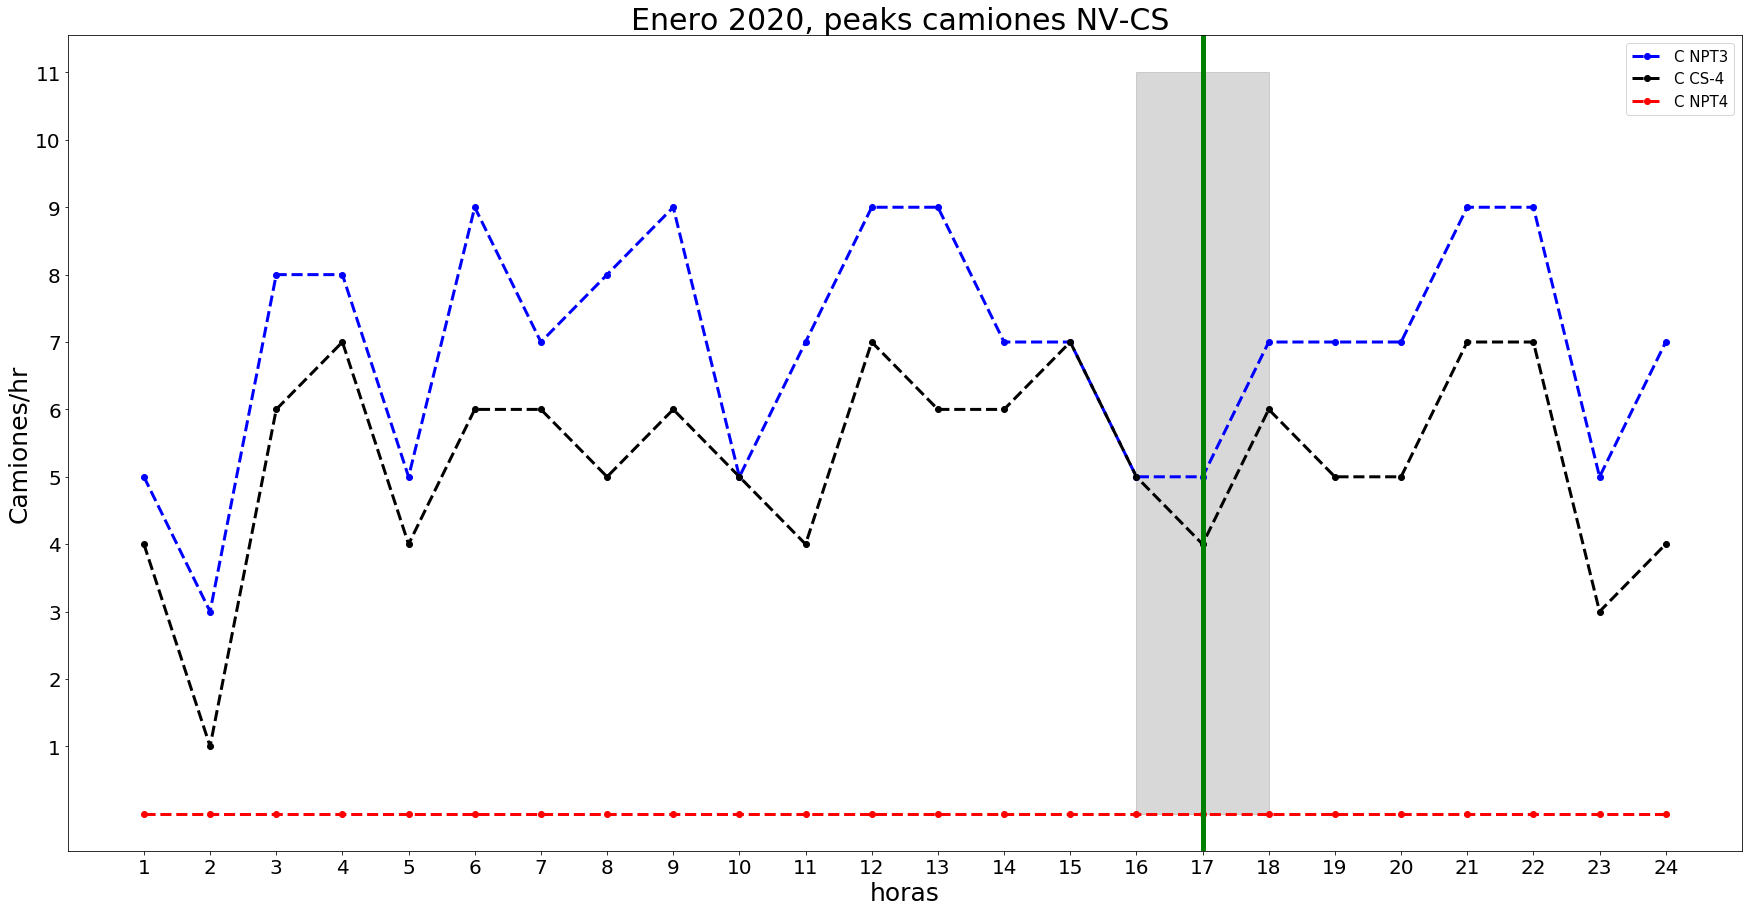

In [46]:
plt.figure(figsize=(30,15))
plt.plot(descarga_zones["C NPT3"],'bo--',lw=3,label='C NPT3')
plt.plot(descarga_zones["C CS-4"],'ko--',lw=3,label='C CS-4')
plt.plot(descarga_zones["C NPT4"],'ro--',lw=3,label='C NPT4')
plt.title("Enero 2020, peaks camiones NV-CS ",fontsize=30)
plt.xlabel("horas",fontsize=25)
plt.ylabel("Camiones/hr",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=20)
plt.yticks(np.arange(1,25,1),fontsize=20)
plt.axvline(x=17,lw=5,c='g')
plt.legend(fontsize=15)
plt.fill_between((16,18), 0, 11,color='gray', alpha=0.3)
plt.show()

# Veamos ahora el comportamiento para Salar-CS

In [28]:
def df_origin_destination(df, zona_1 , zona_2 ,name = None):    
    aux = df[((df['Origin'] == zona_1) | (df['Origin'] == zona_2)) & ((df['Destination'] == zona_1) | (df['Destination'] == zona_2)) ]
    if name != None:
        aux.to_csv(name,index=False)
    return aux

zona_1 = 'Coya Sur'
zona_2 = 'Salar de Atacama'
data_2 = df
data_2 = df_origin_destination(data_2,zona_1,zona_2,"cs-sa.csv")



In [34]:
carga_2 = data_2[data_2['Type'] == 'Carga']
descarga_2 = data_2[data_2['Type'] == 'Descarga']

In [35]:
carga_2

Cycle Id  Year [In]   Type Product    Origin       Destination  \
16      9987680       2019  Carga     NaN  Coya Sur  Salar de Atacama   
69      8706087       2019  Carga     NaN  Coya Sur  Salar de Atacama   
202     9987718       2019  Carga     NaN  Coya Sur  Salar de Atacama   
235     9273797       2019  Carga     NaN  Coya Sur  Salar de Atacama   
425     9226134       2019  Carga     NaN  Coya Sur  Salar de Atacama   
...         ...        ...    ...     ...       ...               ...   
92937  18601914       2020  Carga     NaN  Coya Sur  Salar de Atacama   
92952  18602886       2020  Carga     NaN  Coya Sur  Salar de Atacama   
92981  18606549       2020  Carga     NaN  Coya Sur  Salar de Atacama   
93011  18610026       2020  Carga     NaN  Coya Sur  Salar de Atacama   
93032  18613251       2020  Carga     NaN  Coya Sur  Salar de Atacama   

      Zone Name (1)  Zone Pre Time (1) Zone Start (1) Zone End (1)  ...  \
16            C ATM              695.0       00:43:06     00:52:07  ...   
69           C NPT3             1901.0       08:12:04     08:31:29  ...   
202          C NPT3              873.0       00:48:04     00:57:21  ...   
235          C NPT3             5016.0       10:57:42     11:03:38  ...   
425           C ATM              436.0       10:50:25     11:13:58  ...   
...             ...                ...            ...          ...  ...   
92937        C NPT3             1312.0       09:23:52     09:28:38  ...   
92952     C NPT 1-2             1823.0       10:18:29     10:26:21  ...   
92981     C NPT 1-2             2768.0       11:46:24     11:52:22  ...   
93011        C NPT3             2245.0       13:00:20     13:07:18  ...   
93032        C NPT3             2843.0       14:12:30     14:18:20  ...   

       Zone Time (97) Zone Name (98)  Zone Pre Time (98) Zone Start (98)  \
16                NaN            NaN                 NaN             NaT   
69                NaN            NaN                 NaN             NaT   
202               NaN            NaN                 NaN             NaT   
235               NaN            NaN                 NaN             NaT   
425               NaN            NaN                 NaN             NaT   
...               ...            ...                 ...             ...   
92937             NaN            NaN                 NaN             NaT   
92952             NaN            NaN                 NaN             NaT   
92981             NaN            NaN                 NaN             NaT   
93011             NaN            NaN                 NaN             NaT   
93032             NaN            NaN                 NaN             NaT   

      Zone End (98)  Zone Time (98)   Date [In]  Date [Out] Day of year [In]  \
16              NaT             NaN  2019-07-01  2019-07-01              182   
69              NaT             NaN  2019-07-01  2019-07-01              182   
202             NaT             NaN  2019-07-02  2019-07-02              183   
235             NaT             NaN  2019-07-02  2019-07-02              183   
425             NaT             NaN  2019-07-03  2019-07-03              184   
...             ...             ...         ...         ...              ...   
92937           NaT             NaN  2020-06-07  2020-06-07              159   
92952           NaT             NaN  2020-06-07  2020-06-07              159   
92981           NaT             NaN  2020-06-07  2020-06-07              159   
93011           NaT             NaN  2020-06-07  2020-06-07              159   
93032           NaT             NaN  2020-06-07  2020-06-07              159   

      Day of year [Out]  
16                  182  
69                  182  
202                 183  
235                 183  
425                 184  
...                 ...  
92937               159  
92952               159  
92981               159  
93011               159  
93032               159  

[1852 rows x 500 columns]

In [36]:
descarga_2

Cycle Id  Year [In]      Type   Product            Origin Destination  \
20      9174943       2019  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
37      9878081       2019  Descarga       NaN  Salar de Atacama    Coya Sur   
70     10481822       2019  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
85      8255121       2019  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
86      9226056       2019  Descarga       NaN  Salar de Atacama    Coya Sur   
...         ...        ...       ...       ...               ...         ...   
93136  18626456       2020  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
93138  18626751       2020  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
93192  18633032       2020  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
93198  18633510       2020  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   
93199  18633550       2020  Descarga  MOP-H-BL  Salar de Atacama    Coya Sur   

      Zone Name (1)  Zone Pre Time (1) Zone Start (1) Zone End (1)  ...  \
20            C ATM              385.0       01:28:02     01:36:16  ...   
37           C NPT3              785.0       04:34:39     04:40:42  ...   
70           C NPT3             4730.0       09:01:18     09:10:12  ...   
85        C NPT 1-2             7470.0       10:42:22     10:49:24  ...   
86        C NPT 1-2             7425.0       10:41:55     11:01:40  ...   
...             ...                ...            ...          ...  ...   
93136         C ATM              600.0       19:01:42     19:09:43  ...   
93138        C NPT3             1080.0       19:26:08     19:33:07  ...   
93192           NaN                NaN            NaT          NaT  ...   
93198        C NPT3              715.0       01:46:43     01:53:46  ...   
93199        C NPT3             1175.0       01:55:39     02:01:05  ...   

       Zone Time (97) Zone Name (98)  Zone Pre Time (98) Zone Start (98)  \
20                NaN            NaN                 NaN             NaT   
37                NaN            NaN                 NaN             NaT   
70                NaN            NaN                 NaN             NaT   
85                NaN            NaN                 NaN             NaT   
86                NaN            NaN                 NaN             NaT   
...               ...            ...                 ...             ...   
93136             NaN            NaN                 NaN             NaT   
93138             NaN            NaN                 NaN             NaT   
93192             NaN            NaN                 NaN             NaT   
93198             NaN            NaN                 NaN             NaT   
93199             NaN            NaN                 NaN             NaT   

      Zone End (98)  Zone Time (98)   Date [In]  Date [Out] Day of year [In]  \
20              NaT             NaN  2019-07-01  2019-07-01              182   
37              NaT             NaN  2019-07-01  2019-07-01              182   
70              NaT             NaN  2019-07-01  2019-07-01              182   
85              NaT             NaN  2019-07-01  2019-07-01              182   
86              NaT             NaN  2019-07-01  2019-07-01              182   
...             ...             ...         ...         ...              ...   
93136           NaT             NaN  2020-06-07  2020-06-07              159   
93138           NaT             NaN  2020-06-07  2020-06-07              159   
93192           NaT             NaN  2020-06-08  2020-06-08              160   
93198           NaT             NaN  2020-06-08  2020-06-08              160   
93199           NaT             NaN  2020-06-08  2020-06-08              160   

      Day of year [Out]  
20                  182  
37                  182  
70                  182  
85                  182  
86                  182  
...                 ...  
93136               159  
93138               159  
93192               160  
93198      

In [76]:
descarga_zones_sa = pd.read_csv('CS-SA_enero_max_out.csv')
descarga_zones_sa = descarga_zones_sa.set_index(np.arange(1,25,1))

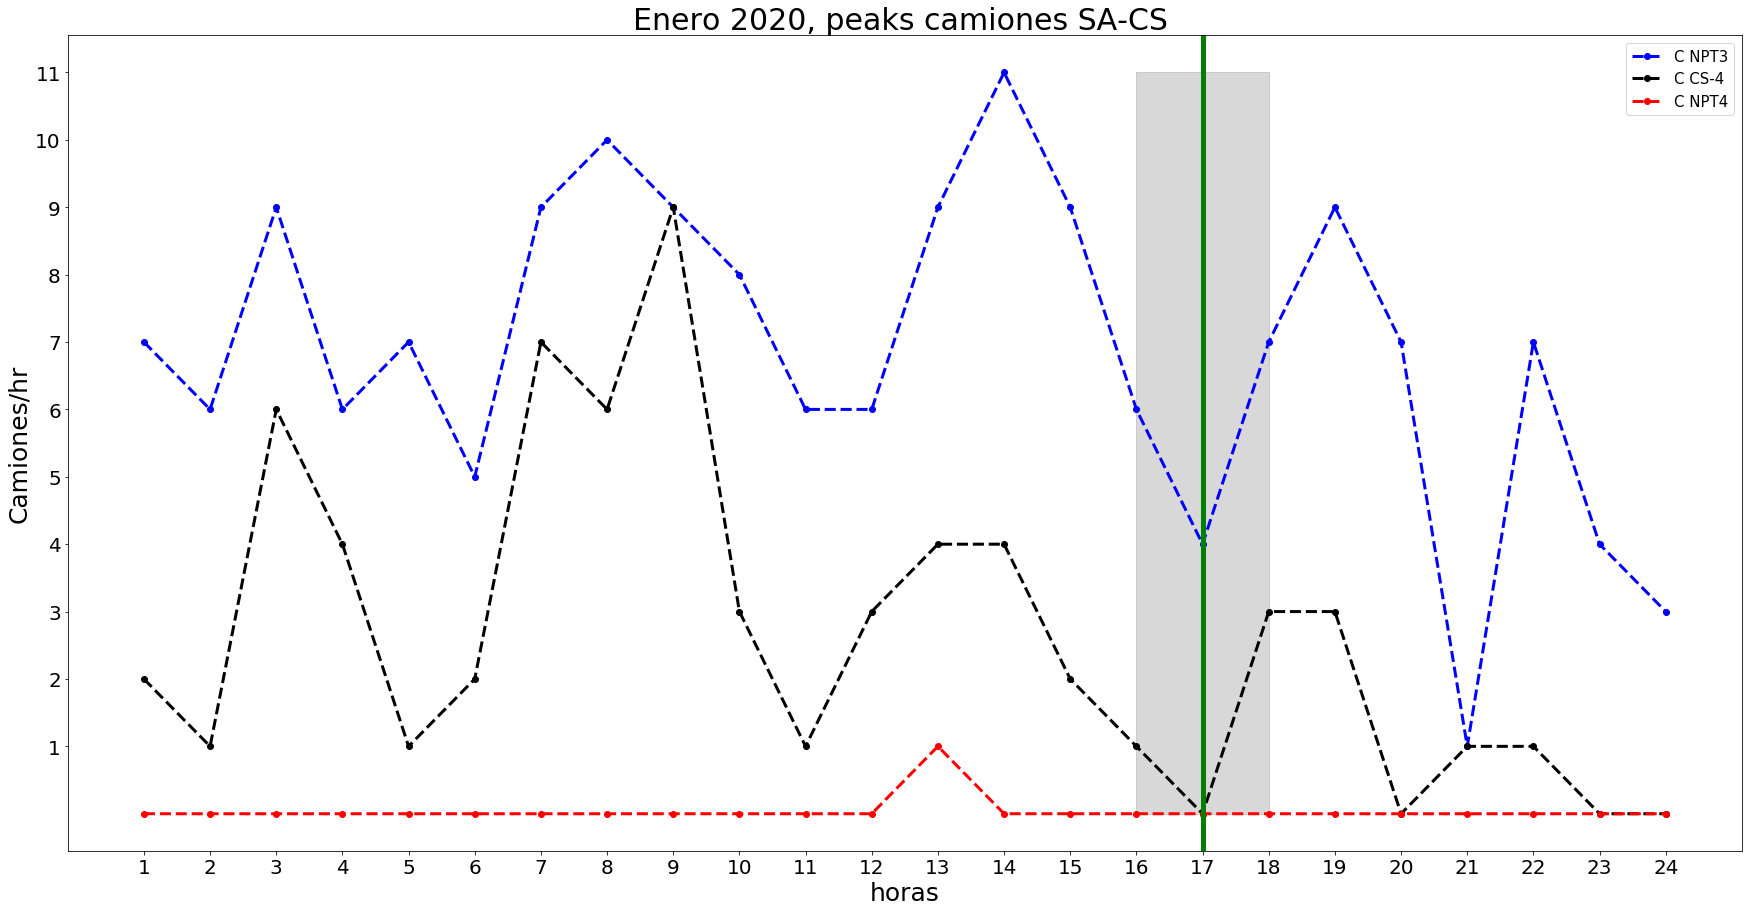

In [49]:
plt.figure(figsize=(30,15))
plt.plot(descarga_zones_sa["C NPT3"],'bo--',lw=3,label='C NPT3')
plt.plot(descarga_zones_sa["C CS-4"],'ko--',lw=3,label='C CS-4')
plt.plot(descarga_zones_sa["C NPT4"],'ro--',lw=3,label='C NPT4')
plt.title("Enero 2020, peaks camiones SA-CS ",fontsize=30)
plt.xlabel("horas",fontsize=25)
plt.ylabel("Camiones/hr",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=20)
plt.yticks(np.arange(1,25,1),fontsize=20)
plt.axvline(x=17,lw=5,c='g')
plt.legend(fontsize=15)
plt.fill_between((16,18), 0, 11,color='gray', alpha=0.3)
plt.show()

# Analicemos por canchas

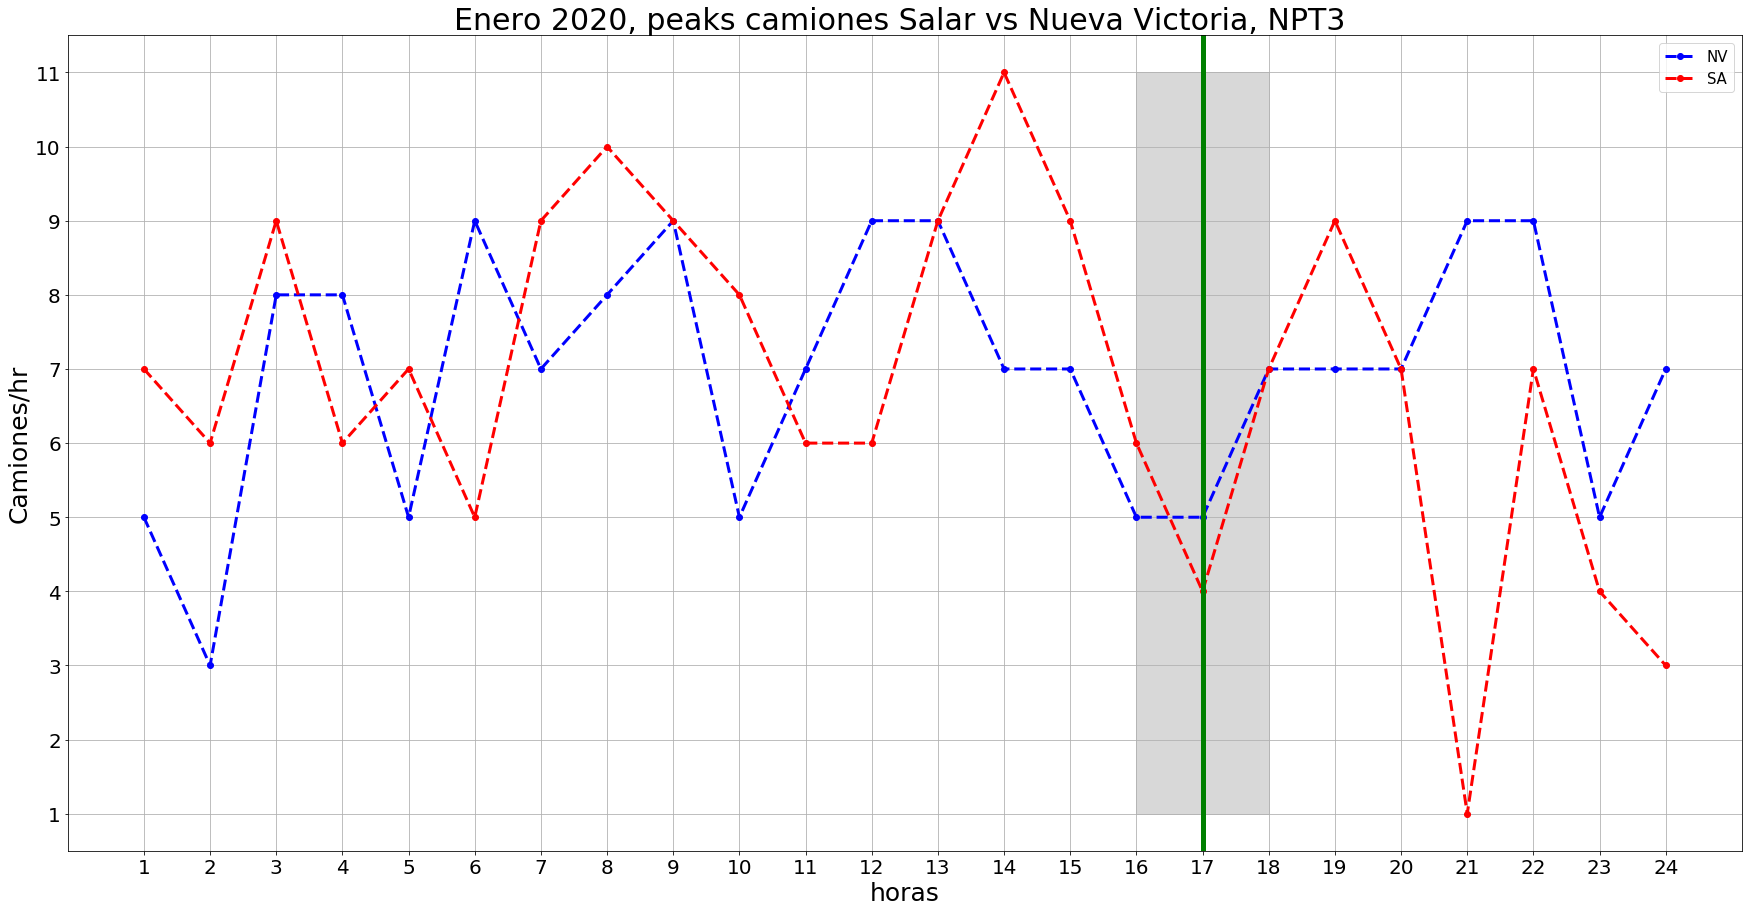

In [58]:
plt.figure(figsize=(30,15))
plt.plot(descarga_zones["C NPT3"],'bo--',lw=3,label='NV')
plt.plot(descarga_zones_sa["C NPT3"],'ro--',lw=3,label='SA')
plt.title("Enero 2020, peaks camiones Salar vs Nueva Victoria, NPT3 ",fontsize=30)
plt.xlabel("horas",fontsize=25)
plt.ylabel("Camiones/hr",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=20)
plt.yticks(np.arange(1,25,1),fontsize=20)
plt.axvline(x=17,lw=5,c='g')
plt.legend(fontsize=15)
plt.fill_between((16,18), 1, 11,color='gray', alpha=0.3)
plt.grid(True)
plt.savefig("SA-NV_peaks_enero_NPT3.png")
plt.show()

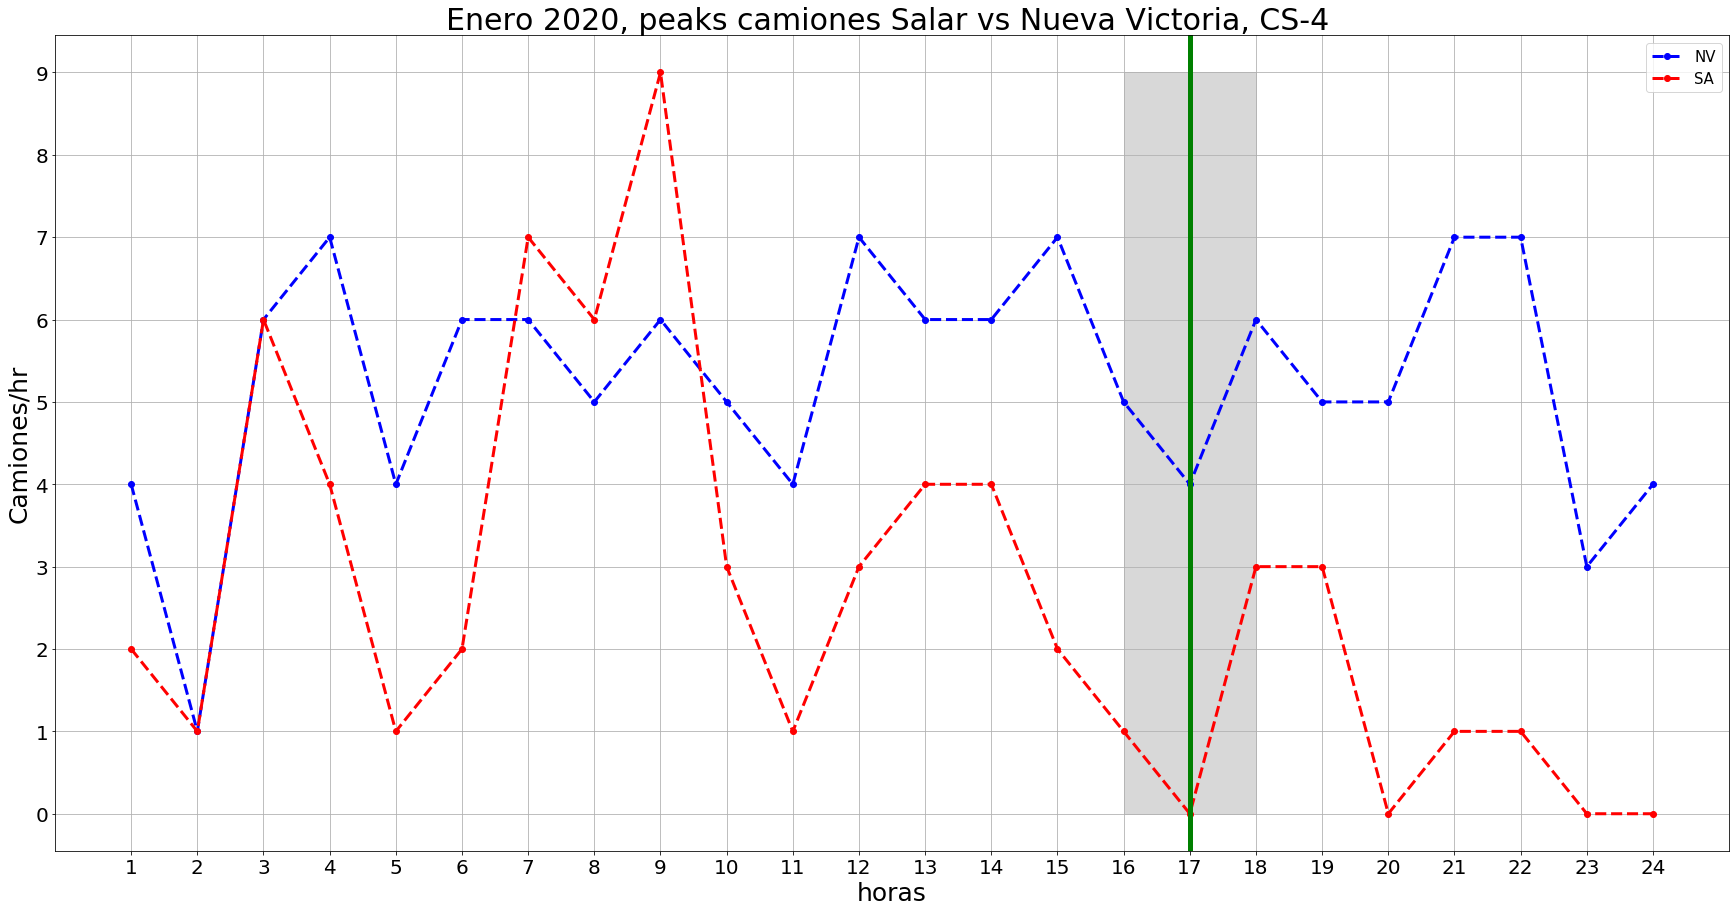

In [57]:
plt.figure(figsize=(30,15))
plt.plot(descarga_zones["C CS-4"],'bo--',lw=3,label='NV')
plt.plot(descarga_zones_sa["C CS-4"],'ro--',lw=3,label='SA')
plt.title("Enero 2020, peaks camiones Salar vs Nueva Victoria, CS-4 ",fontsize=30)
plt.xlabel("horas",fontsize=25)
plt.ylabel("Camiones/hr",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=20)
plt.yticks(np.arange(0,25,1),fontsize=20)
plt.axvline(x=17,lw=5,c='g')
plt.legend(fontsize=15)
plt.fill_between((16,18), 0, 9,color='gray', alpha=0.3)
plt.grid(True)
plt.savefig("SA-NV_peaks_enero_CS-4.png")
plt.show()

In [68]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
count = 0
M = None
for i in range(dias_mes[0][0],dias_mes[0][1]+1):
    print(i)
    aux = dict_to_df(vehiculos_time(descarga_2,i,i,1,25,condition="out",cond='Pre Time'))
    if count == 0:
        M = aux
        count += 1
    else:
        M = pd.concat([M, aux]).max(level=0)   #Aquí indico que necesito los peaks
M.to_csv("CS-NV_enero_max_pretime_out.csv",index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [69]:
pretime_zones = pd.read_csv('CS-NV_enero_max_pretime_out.csv')
pretime_zones = pretime_zones.set_index(np.arange(1,25,1))
pretime_zones

C ATM  C CS-11  C CS-12  C CS-4  C CS-P.Valdivia  C Granulacion  \
1     2.0        0      0.0     2.0                0            0.0   
2     3.0        0      0.0     1.0                0            1.0   
3     4.0        0      0.0     6.0                0            0.0   
4     7.0        0      0.0     4.0                0            1.0   
5     3.0        0      0.0     1.0                0            1.0   
6     2.0        0      1.0     2.0                0            0.0   
7     3.0        0      1.0     7.0                0            0.0   
8     4.0        0      0.0     6.0                0            1.0   
9     3.0        0      0.0     9.0                0            0.0   
10    1.0        0      0.0     3.0                0            0.0   
11    0.0        0      0.0     1.0                0            0.0   
12    4.0        0      0.0     3.0                0            0.0   
13    7.0        0      0.0     4.0                0            0.0   
14    5.0        0      0.0     4.0                0            0.0   
15    2.0        0      0.0     2.0                0            0.0   
16    1.0        0      0.0     1.0                0            0.0   
17    0.0        0      0.0     0.0                0            0.0   
18    7.0        0      0.0     3.0                0            0.0   
19    4.0        0      0.0     3.0                0            0.0   
20    3.0        0      0.0     0.0                0            0.0   
21    2.0        0      0.0     1.0                0            0.0   
22    1.0        0      0.0     1.0                0            0.0   
23    1.0        0      0.0     0.0                0            0.0   
24    0.0        0      0.0     0.0                0            0.0   

    C NPT 1-2  C NPT3  C NPT4  C PTS  C Prilado  C Secado L-3  C Secado L-4  \
1         2.0     7.0     0.0      0        0.0             0           1.0   
2         1.0     6.0     0.0      0        0.0             0           1.0   
3         5.0     9.0     0.0      0        2.0             0           3.0   
4         8.0     6.0     0.0      0        1.0             0           5.0   
5        13.0     7.0     0.0      0        2.0             0           3.0   
6         2.0     5.0     0.0      0        2.0             0           2.0   
7         2.0     9.0     0.0      0        0.0             0           1.0   
8         4.0    10.0     0.0      0        2.0             0           3.0   
9         7.0     9.0     0.0      0        3.0             0           2.0   
10        4.0     8.0     0.0      0        2.0             0           1.0   
11        1.0     6.0     0.0      0        1.0             0           2.0   
12        3.0     6.0     0.0      0        1.0             0           1.0   
13        5.0     9.0     1.0      0        1.0             0           1.0   
14        5.0    11.0     0.0      0        1.0             0           1.0   
15        3.0     9.0     0.0      0        1.0             0           1.0   
16        0.0     6.0     0.0      0        0.0             0           0.0   
17        0.0     4.0     0.0      0        0.0             0           1.0   
18        4.0     7.0     0.0      0        1.0             0           4.0   
19        5.0     9.0     0.0      0        2.0             0           6.0   
20        0.0     7.0     0.0      0        0.0             0           0.0   
21        1.0     1.0     0.0      0        3.0             0           0.0   
22        0.0     7.0     0.0      0        0.0             0           0.0   
23        0.0     4.0     0.0      0        0.0             0           0.0   
24        0.0     3.0     0.0      0        2.0             0           0.0   

    Galpones  Losa Envasado  Romana 3  Romana Mto  Romana Salitre  
1          0              0       2.0         0.0             1.0  
2          0              0       1.0         0.0             2.0  
3          0              0       7.0         1.

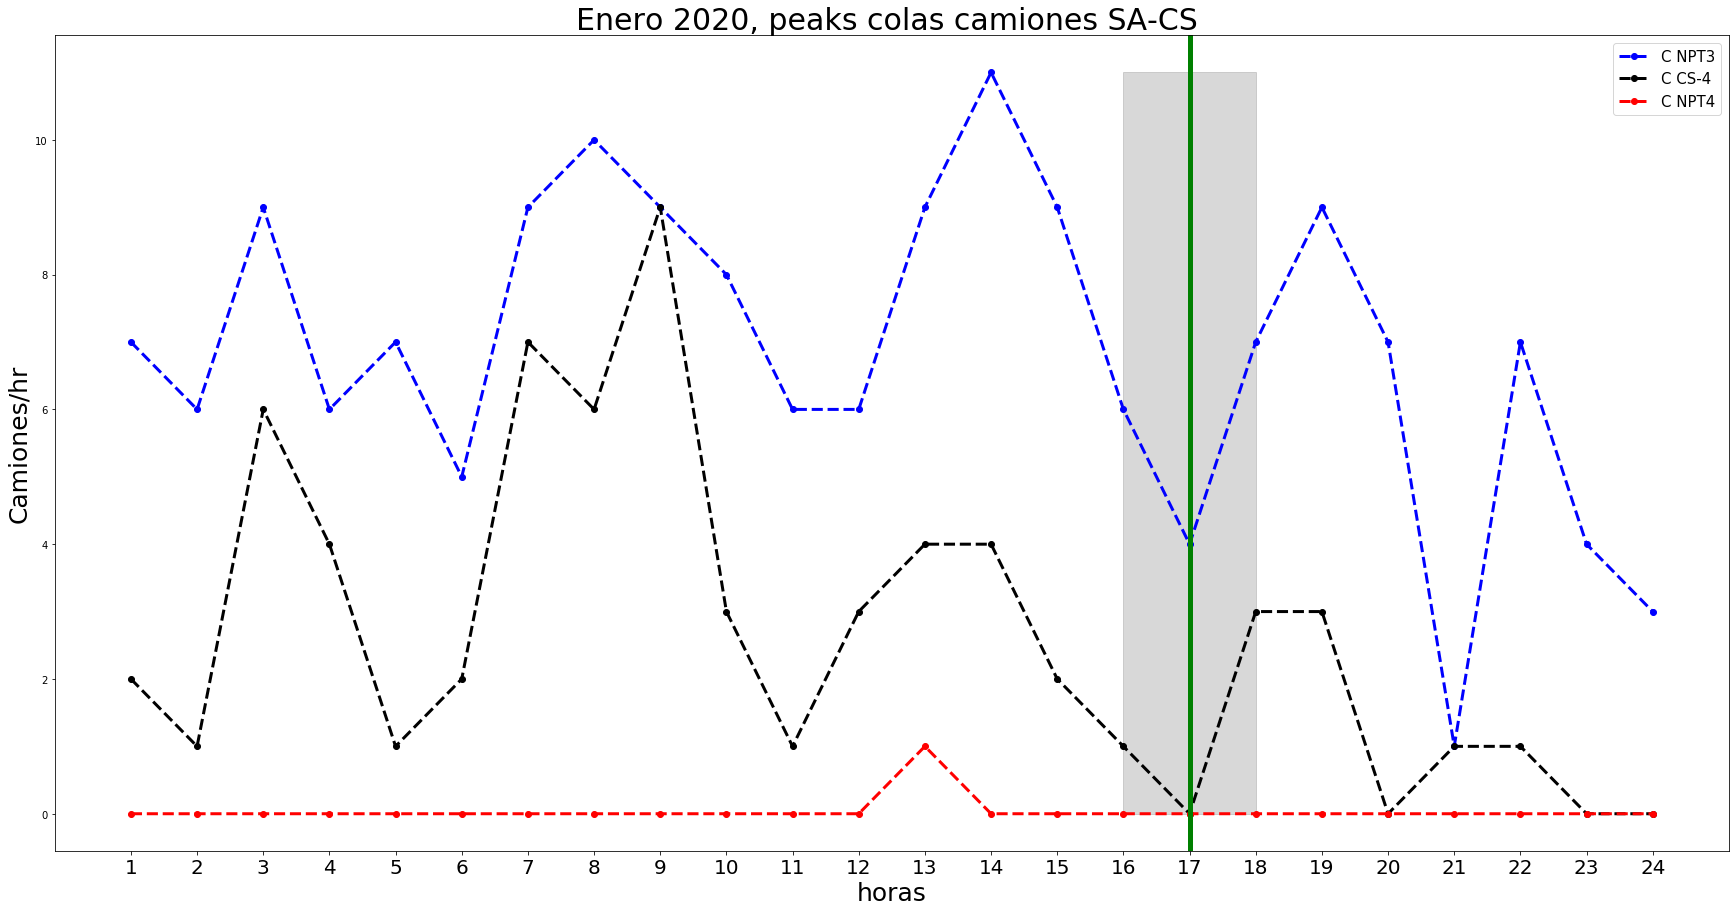

In [71]:
plt.figure(figsize=(30,15))
plt.plot(pretime_zones["C NPT3"],'bo--',lw=3,label='C NPT3')
plt.plot(pretime_zones["C CS-4"],'ko--',lw=3,label='C CS-4')
plt.plot(pretime_zones["C NPT4"],'ro--',lw=3,label='C NPT4')
plt.title("Enero 2020, peaks colas camiones SA-CS ",fontsize=30)
plt.xlabel("horas",fontsize=25)
plt.ylabel("Camiones/hr",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=20)
#plt.yticks(np.arange(1,25,1),fontsize=20)
plt.axvline(x=17,lw=5,c='g')
plt.legend(fontsize=15)
plt.fill_between((16,18), 0, 11,color='gray', alpha=0.3)
plt.show()

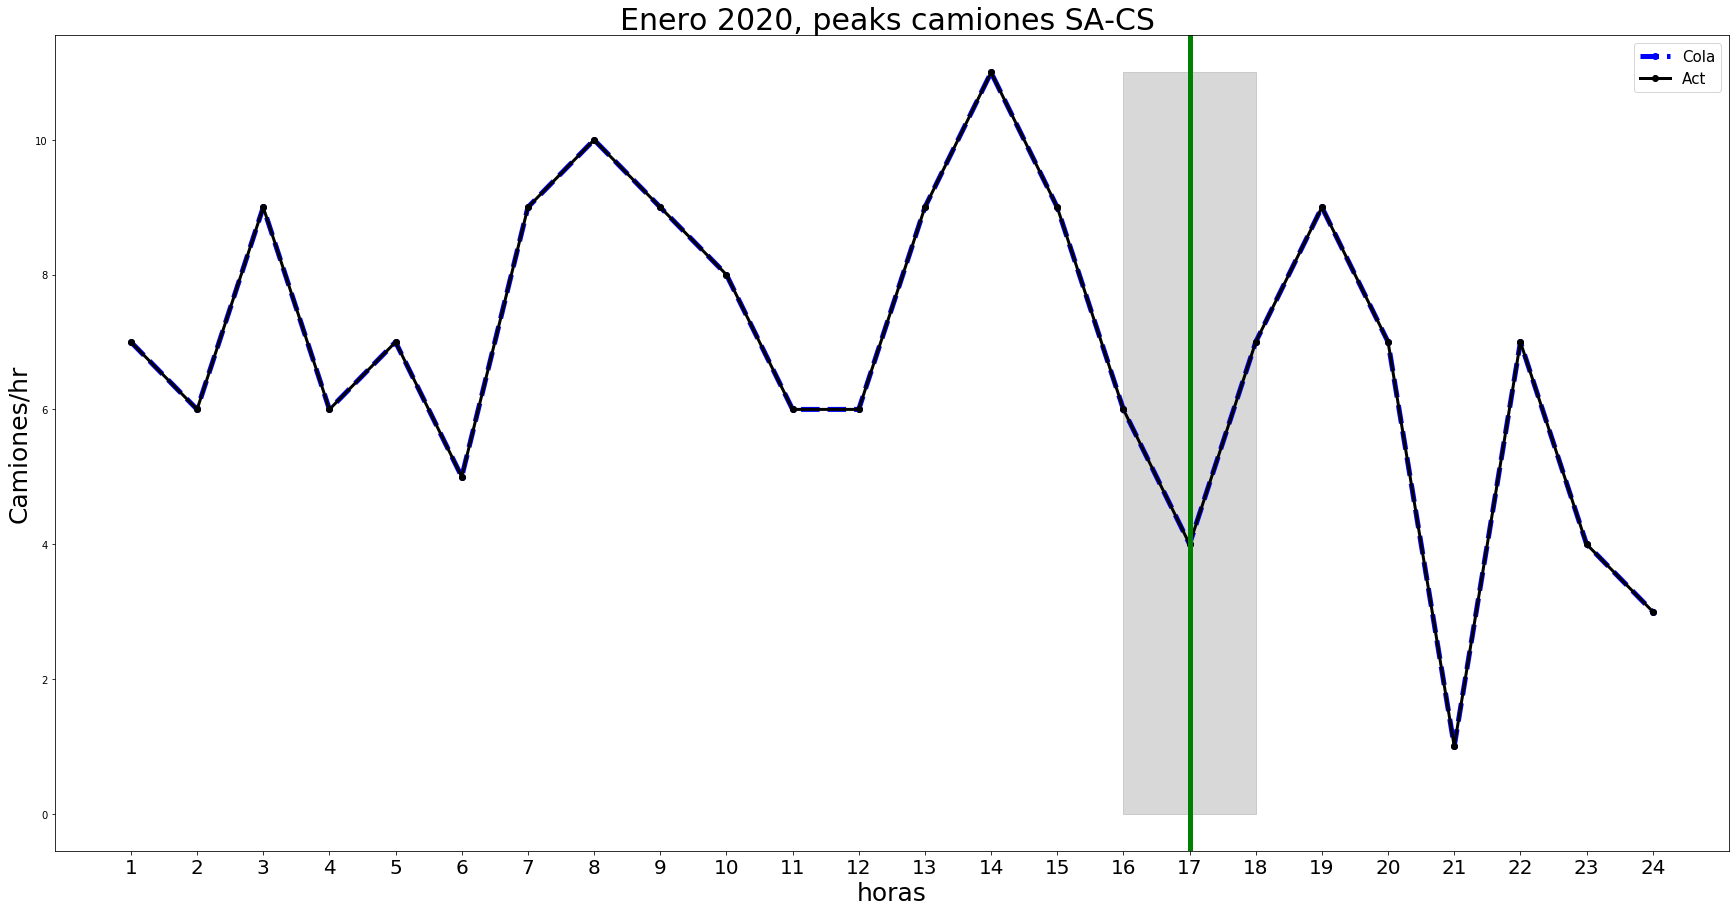

In [79]:
plt.figure(figsize=(30,15))
plt.plot(pretime_zones["C NPT3"],'bo--',lw=5,label='Cola')
plt.plot(descarga_zones_sa["C NPT3"],'ko-',lw=3,label='Act')
plt.title("Enero 2020, peaks camiones SA-CS ",fontsize=30)
plt.xlabel("horas",fontsize=25)
plt.ylabel("Camiones/hr",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=20)
#plt.yticks(np.arange(1,25,1),fontsize=20)
plt.axvline(x=17,lw=5,c='g')
plt.legend(fontsize=15)
plt.fill_between((16,18), 0, 11,color='gray', alpha=0.3)
plt.show()